# Camera analysis by user general

In [27]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import zscore
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate
from scipy.stats import friedmanchisquare

conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryData = """SELECT
               DistancesPerTestCaseTotal.*,
               (((TestCaseData.ObjectDistanceToTarget - TestCaseData.DistanceFinished)/ObjectDistance)) AS PerformanceGeneral
               FROM DistancesPerTestCaseTotal
               RIGHT JOIN TestCaseData
               ON TestCaseData.TestCaseID = DistancesPerTestCaseTotal.TestCaseID"""

observed_group = 'UserID'
tested_variable = 'PerformanceGeneral'

DataCombinedAvg = pd.read_sql_query(queryData, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])[['PerformanceGeneral', 'CameraDistance']].mean().reset_index()

DataCombinedAvgAggregated[f'{tested_variable}_z_within'] = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)


for data in DataCombinedAvgAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

# Analyzing total movement

    ScenarioCase  count      mean       std       min       25%       50%  \
0         FOLDAR   12.0  0.566732  0.136021  0.325544  0.491576  0.552801   
1     FOLDAROPEN   12.0  0.515629  0.096236  0.354874  0.479847  0.538374   
2  STATEOFTHEART   12.0  0.527418  0.083332  0.415290  0.474459  0.510868   

        75%       max  CameraDistance  
0  0.693061  0.739386        4.877591  
1  0.578345  0.621093        6.290196  
2  0.605435  0.645632        6.550636  


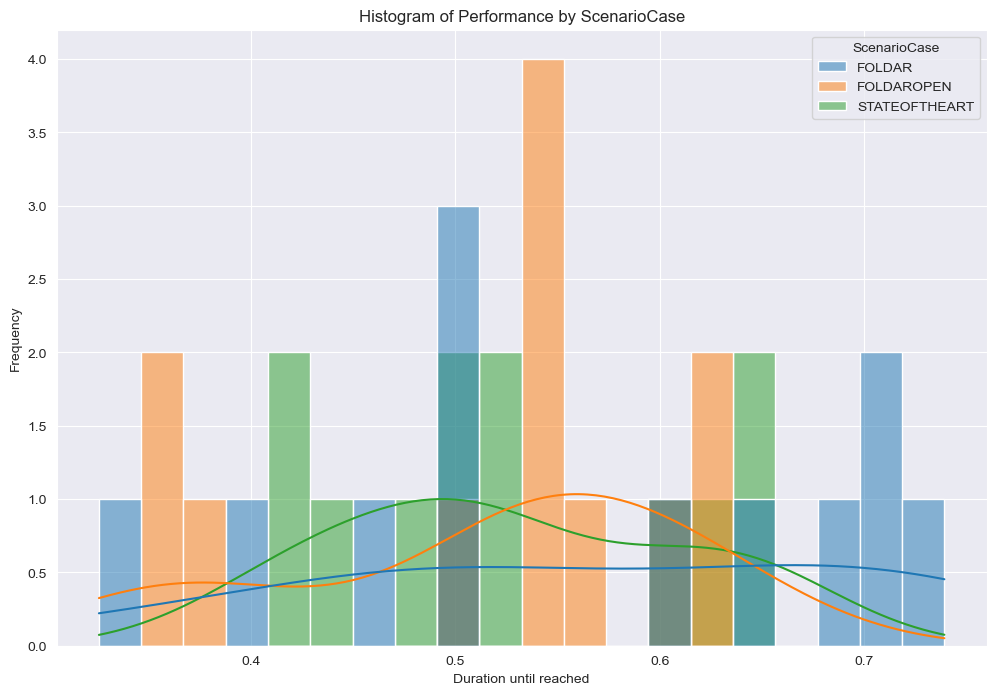

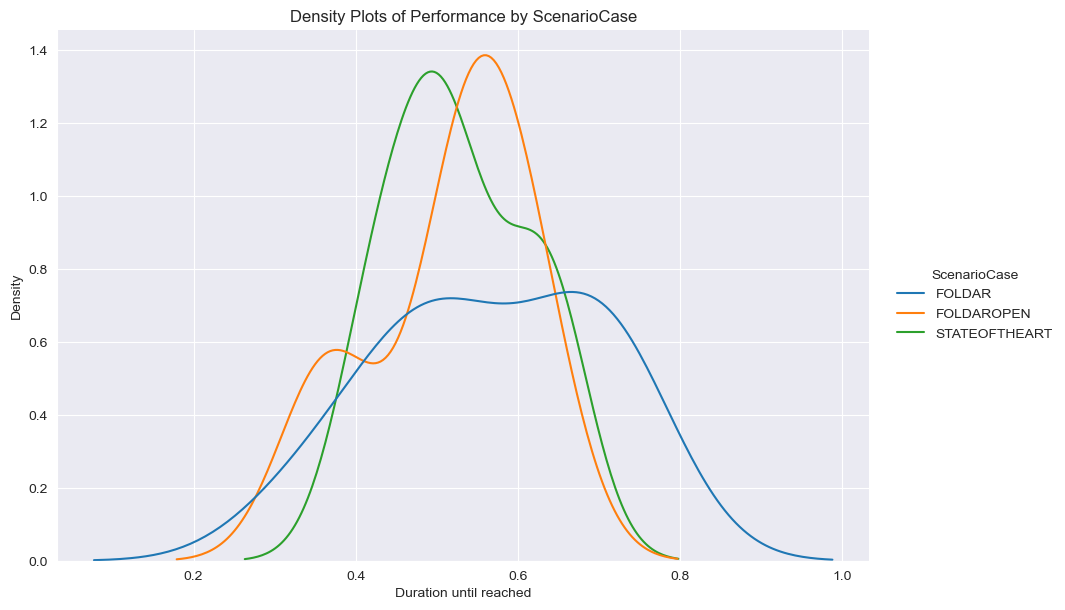

In [28]:
#Average duration for each scenario
summary_stats = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[["CameraDistance"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(combined_output)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataCombinedAvgAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Performance by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataCombinedAvgAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Performance by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Analyzing normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.932958 | p-value: 0.412518
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.846727 | p-value: 0.033458
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.902095 | p-value: 0.168806


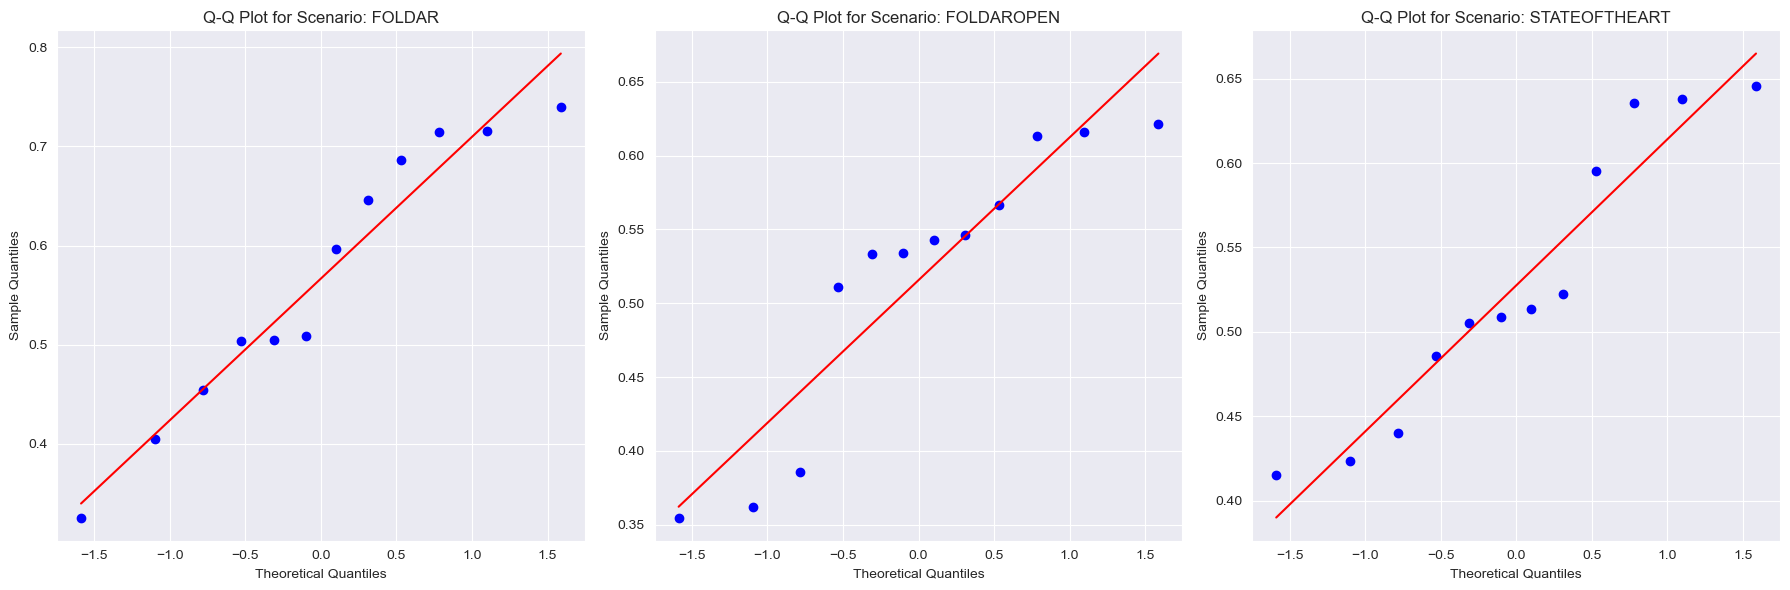

In [29]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.6f} | p-value: {p_value:.6f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Friedman Test

Friedman Test Statistic: 1.5
p-value: 0.4723665527410149
No significant differences found.


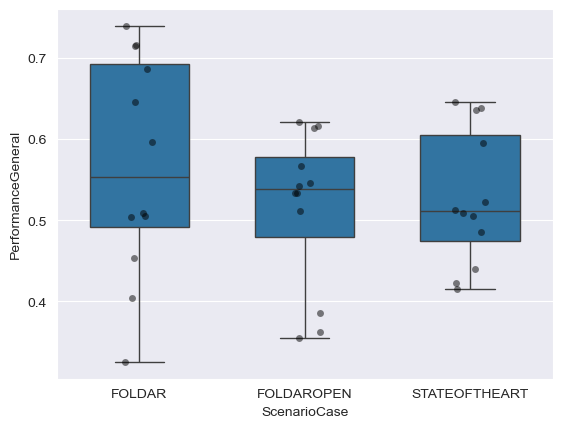

In [30]:
scenario_data = [DataCombinedAvgAggregated[DataCombinedAvgAggregated['ScenarioCase'] == case][tested_variable].values
                 for case in DataCombinedAvgAggregated['ScenarioCase'].unique()]

stat, p_value = friedmanchisquare(*scenario_data)

print(f"Friedman Test Statistic: {stat}")
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant differences exist between the groups (ScenarioCase).")
else:
    print("No significant differences found.")

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=f"{tested_variable}", width=0.6,showfliers=False)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=f"{tested_variable}", color='black', alpha=0.5)
plt.show()